# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
import math
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
Similarity - 
CNN and RNN are both types of neural networks and they both focus on finding patterns (an internal representation) in the input data and build up the patterns from simple to complex.
Difference - 
CNN learns to find structures in data but works better on a single input, whereas RNN can work on sequential data inputs.
CNN works better for cases which have spatial relationship, RNN is better suited to cases where the data has a temporal relationship.

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
LSTM structure provides a "gradient superhighway" and thus alleviates the problem of vanishing or exploding gradients in RNNs.


## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        output_features = hidden_size
        input_features = input_size + hidden_size
        
        # initialize required parameters / layers
        # forget gate
        self.W_f = nn.Parameter(torch.Tensor(output_features, input_features))
        self.b_f = nn.Parameter(torch.Tensor(output_features))
        
        # input gate
        self.W_i = nn.Parameter(torch.Tensor(output_features, input_features))
        self.b_i = nn.Parameter(torch.Tensor(output_features))
        self.W_c = nn.Parameter(torch.Tensor(output_features, input_features))
        self.b_c = nn.Parameter(torch.Tensor(output_features))
        
        # output gate
        self.W_o = nn.Parameter(torch.Tensor(output_features, input_features))
        self.b_o = nn.Parameter(torch.Tensor(output_features))
        
        # reset parameterss
        self.reset_parameters()
        # END TODO #############
    
    def reset_parameters(self):
        
        stdv = 1. / math.sqrt(self.W_f.size(1))
        
        # init weights
        self.W_f.data.uniform_(-stdv, stdv)
        self.W_i.data.uniform_(-stdv, stdv)
        self.W_c.data.uniform_(-stdv, stdv)
        self.W_o.data.uniform_(-stdv, stdv)
        
        # init bias
        self.b_f.data.uniform_(-stdv, stdv)
        self.b_i.data.uniform_(-stdv, stdv)
        self.b_c.data.uniform_(-stdv, stdv)
        self.b_o.data.uniform_(-stdv, stdv)
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        hidden_state, internal_state = hx
        
        # START TODO #############
        x_cat = torch.cat((hidden_state, x), dim=1)
        f_t = torch.sigmoid(F.linear(x_cat ,self.W_f, self.b_f))
        i_t = torch.sigmoid(F.linear(x_cat, self.W_i, self.b_i))
        x_cat_t = torch.tanh(F.linear(x_cat, self.W_c, self.b_c))
        
        # new_internal_state: C_t
        new_internal_state = f_t * internal_state + i_t * x_cat_t
        o_t = torch.sigmoid(F.linear(x_cat, self.W_o, self.b_o))
        new_hidden_state = o_t * torch.tanh(new_internal_state)
        
        # END TODO #############
        return (new_hidden_state, new_internal_state)
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        batch_size = x.shape[0]
        initial_hidden_state = torch.zeros((batch_size, self.hidden_size))
        initial_cell_state = torch.zeros((batch_size, self.hidden_size))
        return (initial_hidden_state, initial_cell_state)
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, new_internal_state). 
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        # iterate over the sequence and apply the LSTM
        output_stacked_hidden = torch.zeros((x.shape[0], x.shape[1], self.hidden_size))
        for i in range(x.shape[0]):
            hx = super(LSTM, self).forward(x[i], hx)
            output_stacked_hidden[i] = hx[0]
        return (output_stacked_hidden, hx)
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

epoch: 0, loss:1.104257345199585
test accuracy: 0.03
epoch: 10, loss:0.014608324505388737
test accuracy: 0.25
epoch: 20, loss:0.02904963307082653
test accuracy: 0.43
epoch: 30, loss:0.02867055870592594
test accuracy: 0.35
epoch: 40, loss:0.010658136568963528
test accuracy: 0.56
epoch: 50, loss:0.004846673924475908
test accuracy: 0.77
epoch: 60, loss:0.006447797641158104
test accuracy: 0.52
epoch: 70, loss:0.0022632936015725136
test accuracy: 0.72
epoch: 80, loss:0.0007537291967310011
test accuracy: 0.96
epoch: 90, loss:0.00027703086379915476
test accuracy: 0.97
epoch: 100, loss:0.00013020995538681746
test accuracy: 0.97


### FEEDBACK - ###

Found this assignment complicated, the pytorch library documentation helped a bit. Time spent > 10 hrs.

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

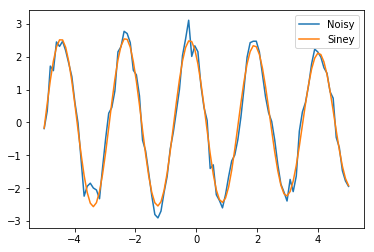

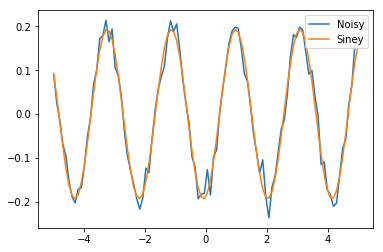

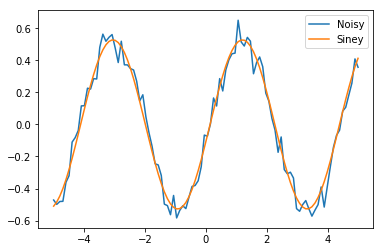

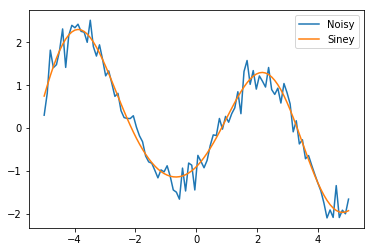

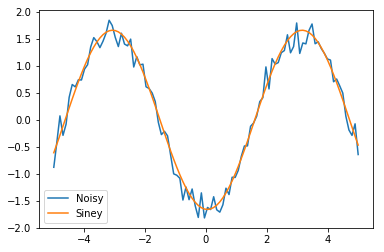

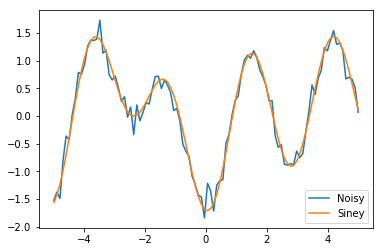

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
sines = sample_sine_functions(6)
z = np.linspace(-5, 5, 100)
for sine in sines:
    plt.plot(z, noisy(sine(z)), label='Noisy')
    plt.plot(z, sine(z), label='Siney')
    plt.legend()
    plt.show()
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (batch_size, hidden_size) followed by a Linear layer which takes a (batch_size, hidden_size) vector as input and outputs a tensor with shape (batch_size, 1).

To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [21]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        self.lstm1 = LSTM(1, hidden_size)
        self.lstm2 = LSTM(hidden_size, hidden_size)
        self.linear = nn.modules.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.shift zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        
        # STUCK
        
        # END TODO #############

In [22]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)


In [23]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    num_samples = noisy_train_sequences.shape[0]
    for epoch in range(num_epochs):
        # START TODO #############
        # training loop here
        for batch_idx in range(num_samples // batch_size):
            optimizer.zero_grad()
            batch = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            output = model(batch)
            labels = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels, output)
            loss.backward()
            optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


In [18]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration| 43.48%               |
| hs=30, shift=15| 41.15%               |
| bs=20, epochs=151, shift=15, hs=80| 51.15%               |

### FEEDBACK ###

I was not able to implement the solution for part 3 properly. I somewhat understand the intuition behind stacking the LSTMs together but got stuck in the implementation part. The shifting of input and everything else is a little confusing for me right now. Time spent almost 4 hours.